# تحليل ديتاست

In [1]:
import os
dataset_path = "../input/chest-xray-covid19-pneumonia/Data"
print("Root folders:",os.listdir(dataset_path)) 
print("Train classes:",os.listdir(os.path.join(dataset_path,'train')))
print("Test  classes:",os.listdir(os.path.join(dataset_path,'test')))

Root folders: ['test', 'train']
Train classes: ['PNEUMONIA', 'NORMAL', 'COVID19']
Test  classes: ['PNEUMONIA', 'NORMAL', 'COVID19']


In [2]:
import glob
from collections import Counter

train_path=os.path.join(dataset_path,'train')
test_path=os.path.join(dataset_path,'test')
class_train=os.listdir(train_path)
class_test=os.listdir(test_path)

train_counts,test_counts,train_format,test_format={},{},[],[]

for _ in class_train:
    class_dir=os.path.join(train_path,_)
    files=glob.glob(f"{class_dir}/*")
    train_counts[_]=len(files)
    train_format+=[os.path.splitext(f)[1].lower() for f in files]

train_format=Counter(train_format)
for _ in class_test:
    class_dir=os.path.join(test_path,_)
    files=glob.glob(f"{class_dir}/*")
    test_counts[_]=len(files)
    test_format+=[os.path.splitext(f)[1].lower() for f in files]

test_format=Counter(test_format)
print("Train counts:",train_counts)
print("Train formats:",train_format)       
print("Test  counts:",test_counts)
print("Test  formats:",test_format)

Train counts: {'PNEUMONIA': 3418, 'NORMAL': 1266, 'COVID19': 460}
Train formats: Counter({'.jpg': 5144})
Test  counts: {'PNEUMONIA': 855, 'NORMAL': 317, 'COVID19': 116}
Test  formats: Counter({'.jpg': 1288})


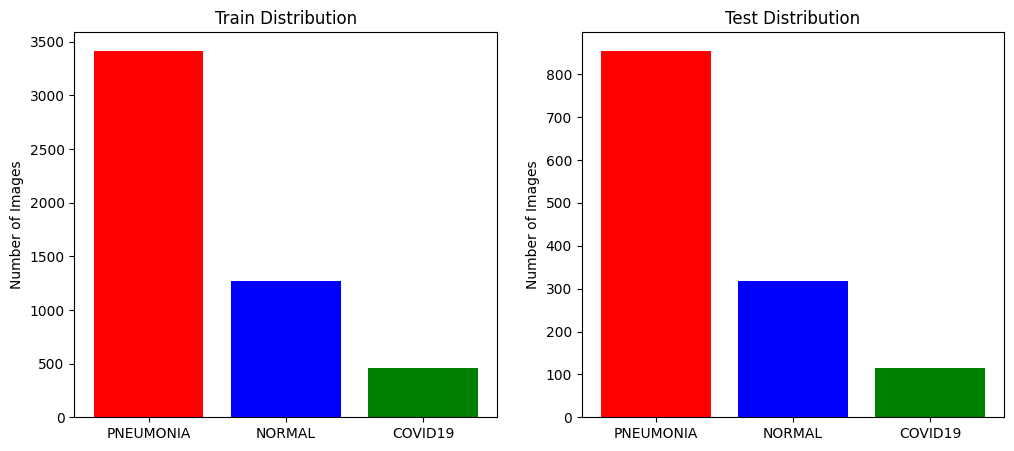

In [3]:
import matplotlib.pyplot as plt

classes=list(train_counts.keys())
train_vals=[train_counts[_] for _ in classes]
test_vals=[test_counts[_]   for _ in classes]
x=range(len(classes))

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.bar(x,train_vals,color=['red','blue','green'])
plt.xticks(x,classes)
plt.ylabel("Number of Images")
plt.title("Train Distribution")   

plt.subplot(1, 2, 2)
plt.bar(x,test_vals,color=['red','blue','green'])
plt.xticks(x,classes)
plt.ylabel("Number of Images")
plt.title("Test Distribution")

plt.show()

# پيش پردازش داده‌ها

In [4]:
import os,random,shutil
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img,img_to_array
from tqdm import tqdm


def min_class_size(split_dir):
    return min(len(os.listdir(os.path.join(split_dir,cls)))
               for cls in os.listdir(split_dir))

min_train=min_class_size(train_path)
min_test=min_class_size(test_path)

def sample_and_copy(src_dir,dst_dir,n,split_name):
    os.makedirs(dst_dir, exist_ok=True)
    for cls in tqdm(os.listdir(src_dir),
                    desc=f"Sampling {split_name}",unit="cls"):
        src_cls=os.path.join(src_dir,cls)
        dst_cls=os.path.join(dst_dir,cls)
        os.makedirs(dst_cls,exist_ok=True)
        files=os.listdir(src_cls)
        for fname in random.sample(files,n):
            shutil.copy(os.path.join(src_cls,fname),
                        os.path.join(dst_cls,fname))

balanced_train='/kaggle/working/balanced_train'
balanced_test='/kaggle/working/balanced_test'
sample_and_copy(train_path,balanced_train,min_train,"Train")
sample_and_copy(test_path,balanced_test,min_test,"Test")

datagen=ImageDataGenerator(
          rotation_range=15,width_shift_range=0.10,height_shift_range=0.10,
          zoom_range=0.10,brightness_range=[0.8,1.2],horizontal_flip=True,
          fill_mode='nearest')

def augment_and_save(src_dir,dst_dir,times=5,split_name="Train"):
    os.makedirs(dst_dir,exist_ok=True)
    for cls in tqdm(os.listdir(src_dir),
                    desc=f"Augmenting {split_name}",unit="cls"):
        src_cls=os.path.join(src_dir,cls)
        dst_cls=os.path.join(dst_dir,cls)
        os.makedirs(dst_cls,exist_ok=True)
        for fname in tqdm(os.listdir(src_cls),
                          desc=f" {cls}",unit="img",leave=False):
            img_path=os.path.join(src_cls,fname)
            img=img_to_array(load_img(img_path))
            x=img.reshape((1,)+img.shape)
            gen=datagen.flow(
                x,batch_size=1,
                save_to_dir=dst_cls,
                save_prefix='aug',
                save_format='jpeg'
            )
            for _ in range(times):
                next(gen)

augment_and_save(balanced_train,'/kaggle/working/augmented_train',times=5,split_name="Train")
augment_and_save(balanced_test,'/kaggle/working/augmented_test',times=5,split_name="Test")



 COVID19:  48%|████▊     | 219/460 [15:41<18:29,  4.60s/img]

Augmenting Test: 100%|██████████| 3/3 [21:01<00:00, 420.53s/cls]


In [7]:
os.environ['KAGGLE_USERNAME']='alirezanajafimot'
os.environ['KAGGLE_KEY']='fd4d440720791c8cdd517a7ff32e3874'  

NEW_DS='/kaggle/working/new_dataset'
os.makedirs(NEW_DS,exist_ok=True)
if not os.path.exists(NEW_DS):
    raise RuntimeError(f"Could not create directory: {NEW_DS}")

import json
meta={
  "title":"Augmented Chest X-ray COVID-19vsPneumoniavsNorm",
  "id":"alirezanajafimot/augmented-chest-xray-covid19-pneumonia",
  "licenses":[{"name":"CC0-1.0"}]
}
with open(f"{NEW_DS}/dataset-metadata.json","w") as f:
    json.dump(meta,f,indent=4)

with open(f"{NEW_DS}/README.md","w") as f:
    f.write("# Augmented Chest X-ray Dataset\n\nThis dataset contains chest X-ray images for COVID-19, Pneumonia, and Normal cases.")


!kaggle datasets create -p /kaggle/working/new_dataset -u

Starting upload for file README.md
100%|████████████████████████████████████████████| 116/116 [00:00<00:00, 184B/s]
Upload successful: README.md (116B)
Your public Dataset is being created. Please check progress at https://www.kaggle.com/datasets/alirezanajafimot/augmented-chest-xray-covid19-pneumonia


In [23]:
import shutil

src_dir_train='/kaggle/working/augmented_train'
src_dir_test='/kaggle/working/augmented_test'

NEW_DS_train=os.path.join(NEW_DS,'augmented_train')
NEW_DS_test=os.path.join(NEW_DS,'augmented_test')

os.makedirs(NEW_DS_train,exist_ok=True)
os.makedirs(NEW_DS_test,exist_ok=True)

for cls in classes:
    cls_dir_train=os.path.join(NEW_DS_train,cls)
    os.makedirs(cls_dir_train,exist_ok=True)
    
    src_cls_dir_train=os.path.join(src_dir_train,cls)
    for filename in os.listdir(src_cls_dir_train):
        if filename.endswith(".jpeg"):
            shutil.copy(
                os.path.join(src_cls_dir_train,filename),
                os.path.join(cls_dir_train,filename)
            )

!kaggle datasets version -p {NEW_DS} -m "Updated dataset with new files" --dir-mode zip

Starting upload for file augmented_train.zip
100%|████████████████████████████████████████| 899M/899M [00:09<00:00, 96.6MB/s]
Upload successful: augmented_train.zip (899MB)
Starting upload for file augmented_test.zip
100%|█████████████████████████████████████████| 22.0/22.0 [00:00<00:00, 35.2B/s]
Upload successful: augmented_test.zip (22B)
Starting upload for file README.md
100%|████████████████████████████████████████████| 116/116 [00:00<00:00, 201B/s]
Upload successful: README.md (116B)
Dataset version is being created. Please check progress at https://www.kaggle.com/alirezanajafimot/augmented-chest-xray-covid19-pneumonia


In [24]:
for cls in classes:
    cls_dir_test=os.path.join(NEW_DS_test,cls)
    os.makedirs(cls_dir_test,exist_ok=True)
    
    src_cls_dir_test=os.path.join(src_dir_test,cls)
    for filename in os.listdir(src_cls_dir_test):
        if filename.endswith(".jpeg"):
            shutil.copy(
                os.path.join(src_cls_dir_test,filename),
                os.path.join(cls_dir_test,filename)
            )

!kaggle datasets version -p {NEW_DS} -m "Updated dataset with new files" --dir-mode zip

Starting upload for file augmented_train.zip
100%|████████████████████████████████████████| 899M/899M [00:11<00:00, 81.1MB/s]
Upload successful: augmented_train.zip (899MB)
Starting upload for file augmented_test.zip
100%|████████████████████████████████████████| 263M/263M [00:03<00:00, 79.1MB/s]
Upload successful: augmented_test.zip (263MB)
Starting upload for file README.md
100%|████████████████████████████████████████████| 116/116 [00:00<00:00, 191B/s]
Upload successful: README.md (116B)
Dataset version is being created. Please check progress at https://www.kaggle.com/alirezanajafimot/augmented-chest-xray-covid19-pneumonia


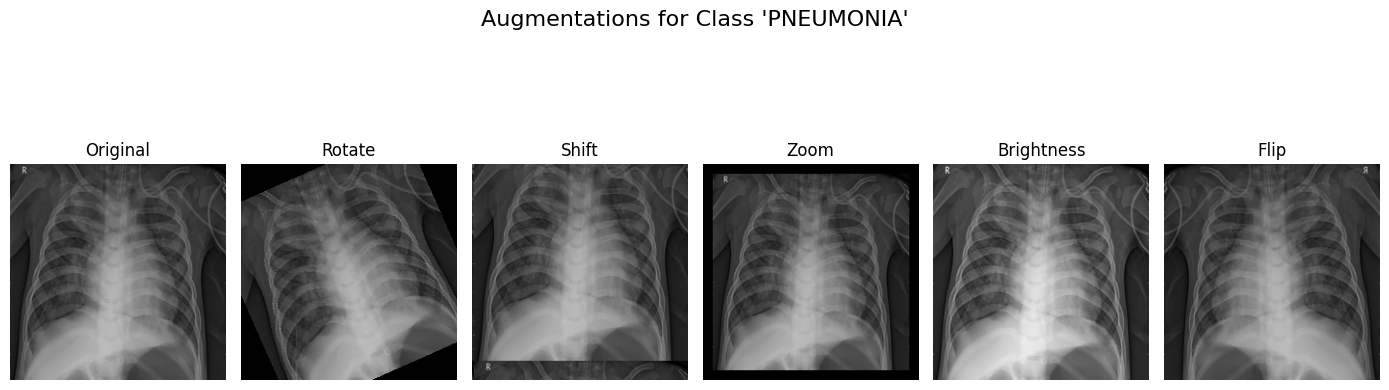

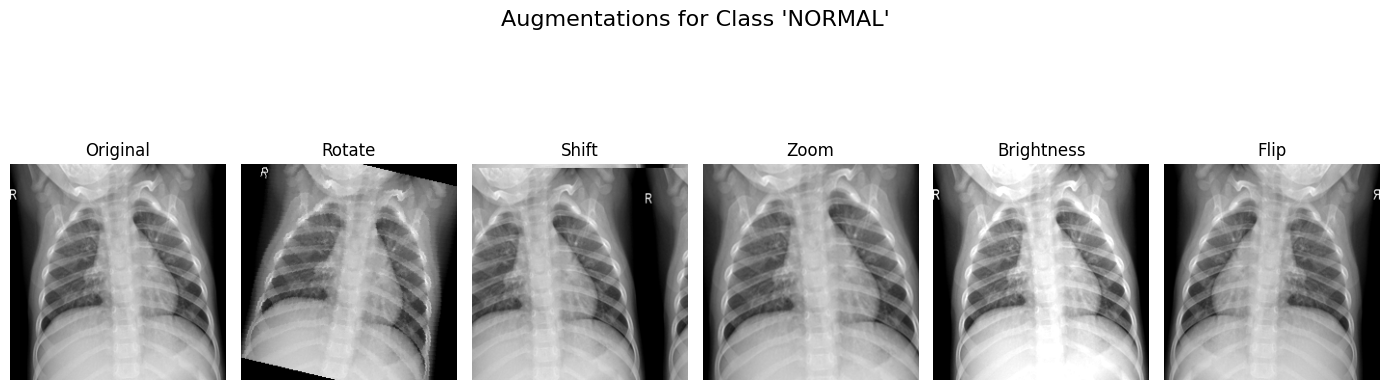

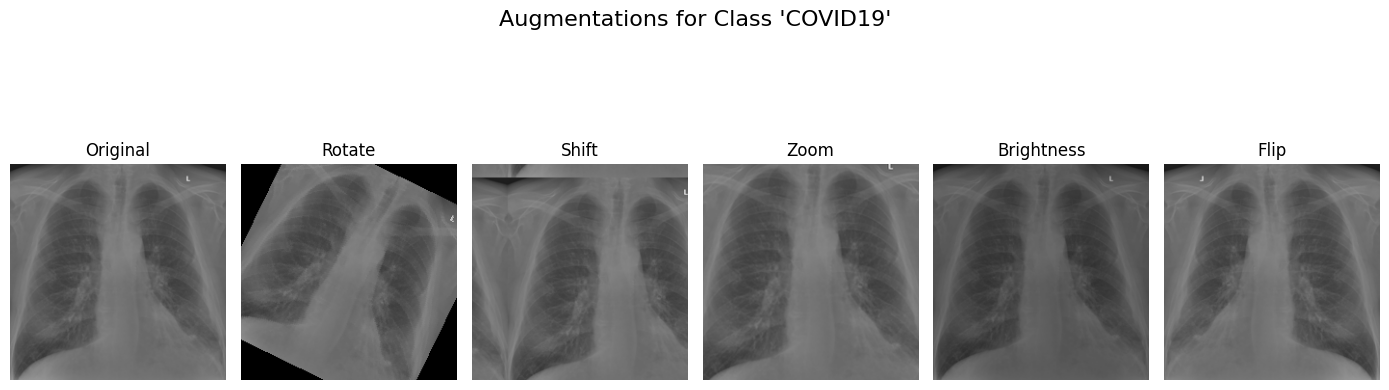

In [14]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image,ImageEnhance,ImageOps,ImageChops

classes=os.listdir(train_path)
sample_paths={
    cls:os.path.join(train_path,cls,random.choice(os.listdir(os.path.join(train_path,cls))))
    for cls in classes
}
def rotate_image(img):
    return img.rotate(random.uniform(-30,30))

def shift_image(img):
    max_shift=int(0.2*img.size[0])
    return ImageChops.offset(img,
                             random.randint(-max_shift,max_shift),
                             random.randint(-max_shift,max_shift))

def zoom_image(img):
    w,h=img.size
    factor=random.uniform(0.8,1.2)
    new_w,new_h=int(w*factor),int(h*factor)
    zoomed=img.resize((new_w,new_h),Image.LANCZOS)
    if factor>1:
        left=(new_w-w)//2;top=(new_h-h)//2
        return zoomed.crop((left,top,left+w,top+h))
    else:
        pad_w=(w-new_w)//2;pad_h=(h-new_h)//2
        return ImageOps.expand(zoomed,border=(pad_w,pad_h),fill='black')

def brightness_image(img):
    enhancer=ImageEnhance.Brightness(img)
    return enhancer.enhance(random.uniform(0.5,1.5))

def flip_image(img):
    return img.transpose(Image.FLIP_LEFT_RIGHT)

augment_methods={
    'Rotate':rotate_image,
    'Shift':shift_image,
    'Zoom':zoom_image,
    'Brightness':brightness_image,
    'Flip':flip_image
}

for cls,img_path in sample_paths.items():
    img=Image.open(img_path).convert('RGB').resize((224,224))
    
    plt.figure(figsize=(14,5))
    plt.suptitle(f"Augmentations for Class '{cls}'", fontsize=16)
    
    plt.subplot(1,len(augment_methods)+1,1)
    plt.imshow(img)
    plt.axis('off')
    plt.title('Original')

    for i,(name,func) in enumerate(augment_methods.items(),start=2):
        aug=func(img)
        plt.subplot(1,len(augment_methods)+1,i)
        plt.imshow(aug)
        plt.axis('off')
        plt.title(name)
    
    plt.tight_layout(rect=[0,0.03,1,0.95])
    plt.show()


# آماده‌سازی مدل

In [8]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Flatten,Dense,Dropout,BatchNormalization,Input
input_shape=(150,150,3)
filter1_size=64
filter2_size=64
filter3_size=128
filter4_size=128
filter5_size=256
filter6_size=256
filter_shape=(3,3)
pooling_shape=(2,2)
dense_layer1=512
dense_layer2=256
out_layer=len(classes)
dropout_rate=0.2

model = Sequential()
model.add(Input(input_shape))
model.add(Conv2D(filter1_size,filter_shape,activation='relu',padding="same"))
model.add(BatchNormalization(axis=-1))
model.add(MaxPooling2D(pooling_shape))
model.add(Dropout(dropout_rate))
model.add(Conv2D(filter2_size,filter_shape,activation='relu',padding='same'))
model.add(BatchNormalization(axis=-1))
model.add(MaxPooling2D(pooling_shape))
model.add(Dropout(dropout_rate))

model.add(Conv2D(filter3_size,filter_shape,activation='relu',padding='same'))
model.add(BatchNormalization(axis=-1))
model.add(MaxPooling2D(pooling_shape))
model.add(Dropout(dropout_rate))

model.add(Conv2D(filter4_size,filter_shape,activation='relu',padding='same'))
model.add(BatchNormalization(axis=-1))
model.add(MaxPooling2D(pooling_shape))
model.add(Dropout(dropout_rate))

model.add(Conv2D(filter5_size,filter_shape,activation='relu',padding='same'))
model.add(BatchNormalization(axis=-1))
model.add(MaxPooling2D(pooling_shape))
model.add(Dropout(dropout_rate))

model.add(Conv2D(filter6_size,filter_shape,activation='relu',padding='same'))
model.add(BatchNormalization(axis=-1))
model.add(MaxPooling2D(pooling_shape))
model.add(Dropout(dropout_rate))
model.add(GlobalAveragePooling2D())
model.add(Flatten())

model.add(Dense(dense_layer1,activation='relu'))
model.add(Dense(dense_layer2,activation='relu'))
model.add(Dense(out_layer,activation='softmax'))
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)                   │ (None, 150, 150, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_12               │ (None, 150, 150, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 75, 75, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 75, 75, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 75, 75, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_13               │ (None, 75, 75, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 37, 37, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 37, 37, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 37, 37, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_14               │ (None, 37, 37, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_14 (MaxPooling2D)      │ (None, 18, 18, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 18, 18, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 18, 18, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_15               │ (None, 18, 18, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_15 (MaxPooling2D)      │ (None, 9, 9, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 9, 9, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 9, 9, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_16               │ (None, 9, 9, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_16 (MaxPooling2D)      │ (None, 4, 4, 256)           │              

 Total params: 1,412,675 (5.39 MB)

 Trainable params: 1,410,883 (5.38 MB)

 Non-trainable params: 1,792 (7.00 KB)

# آموزش و ارزیابی مدل

In [5]:
from tensorflow.keras.preprocessing.image import load_img,img_to_array
from tensorflow.keras.utils import to_categorical

img_width=150
img_height=150

train_dir='../input/augmented-chest-xray-covid19-pneumonia/augmented_train'
test_dir='../input/augmented-chest-xray-covid19-pneumonia/augmented_test'

cls_names=sorted(os.listdir(train_dir))
num_cls=len(cls_names)

def load_dataset(directory):
    images=[]
    labels=[]
    
    for cls_name in cls_names:
        cls_path=os.path.join(directory,cls_name)
        cls_index=cls_names.index(cls_name)
        
        for img_file in os.listdir(cls_path):
            img_path=os.path.join(cls_path,img_file)
            img=load_img(img_path,target_size=(img_height,img_width))
            img_array=img_to_array(img)
            img_array=img_array/255.0
            
            images.append(img_array)
            labels.append(cls_index)
    
    images=np.array(images)
    labels=np.array(labels)
    
    indices=np.arange(len(images))
    np.random.shuffle(indices)
    
    return images[indices],labels[indices]

x_train,y_train=load_dataset(train_dir)
x_test,y_test=load_dataset(test_dir)

y_train=to_categorical(y_train,num_classes=num_cls)
y_test=to_categorical(y_test,num_classes=num_cls)

print("Training set shape:",x_train.shape,y_train.shape)
print("Test set shape:",x_test.shape,y_test.shape)
print("Class names:",cls_names)

Training set shape: (6170, 150, 150, 3) (6170, 3)
Test set shape: (1686, 150, 150, 3) (1686, 3)
Class names: ['COVID19', 'NORMAL', 'PNEUMONIA']


Epoch 1/40
126/126 ━━━━━━━━━━━━━━━━━━━━ 35s 153ms/step - accuracy: 0.7202 - loss: 0.7188 - val_accuracy: 0.3370 - val_loss: 3.5348
Epoch 2/40
126/126 ━━━━━━━━━━━━━━━━━━━━ 6s 51ms/step - accuracy: 0.8923 - loss: 0.3013 - val_accuracy: 0.3301 - val_loss: 3.5679
Epoch 3/40
126/126 ━━━━━━━━━━━━━━━━━━━━ 6s 51ms/step - accuracy: 0.9187 - loss: 0.2276 - val_accuracy: 0.3838 - val_loss: 3.4472
Epoch 4/40
126/126 ━━━━━━━━━━━━━━━━━━━━ 7s 52ms/step - accuracy: 0.9323 - loss: 0.1954 - val_accuracy: 0.6495 - val_loss: 0.8216
Epoch 5/40
126/126 ━━━━━━━━━━━━━━━━━━━━ 7s 52ms/step - accuracy: 0.9392 - loss: 0.1735 - val_accuracy: 0.5810 - val_loss: 1.4789
Epoch 6/40
126/126 ━━━━━━━━━━━━━━━━━━━━ 7s 52ms/step - accuracy: 0.9407 - loss: 0.1682 - val_accuracy: 0.6398 - val_loss: 1.7932
Epoch 7/40
126/126 ━━━━━━━━━━━━━━━━━━━━ 7s 53ms/step - accuracy: 0.9490 - loss: 0.1394 - val_accuracy: 0.3306 - val_loss: 8.9779
Epoch 8/40
126/126 ━━━━━━━━━━━━━━━━━━━━ 7s 53ms/step - accuracy: 0.9449 - loss: 0.1467 - val_ac

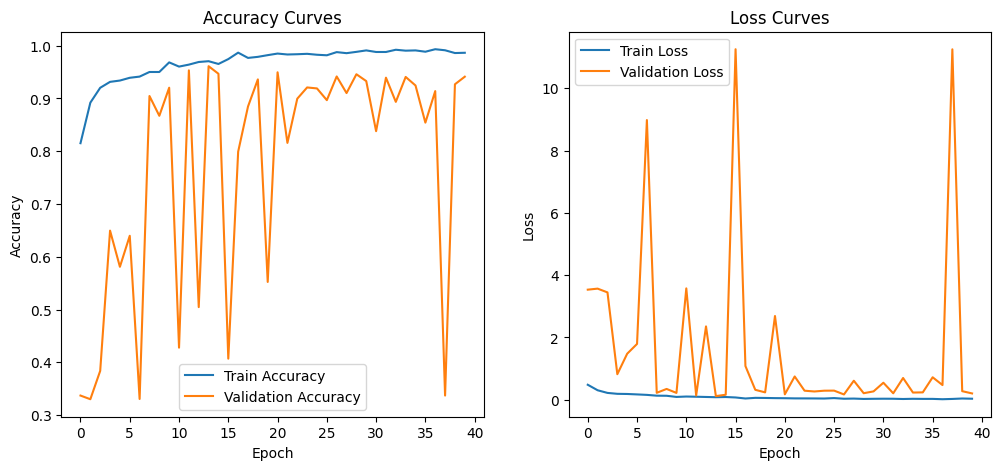

In [10]:
history=model.fit(x_train,y_train,validation_split=0.35,
                  epochs=40,verbose=1
                 )

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'],label='Train Accuracy')
plt.plot(history.history['val_accuracy'],label='Validation Accuracy')
plt.title('Accuracy Curves')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'],label='Train Loss')
plt.plot(history.history['val_loss'],label='Validation Loss')
plt.title('Loss Curves')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.show()

In [11]:
from tensorflow.keras.optimizers import Adam

def build_cnn_model(learning_rate):
    model=Sequential()
    model.add(Input(input_shape))
    model.add(Conv2D(filter1_size,filter_shape,activation='relu',padding='same'))
    model.add(BatchNormalization(axis=-1))
    model.add(MaxPooling2D(pooling_shape))
    model.add(Dropout(dropout_rate))

    model.add(Conv2D(filter2_size,filter_shape,activation='relu',padding='same'))
    model.add(BatchNormalization(axis=-1))
    model.add(MaxPooling2D(pooling_shape))
    model.add(Dropout(dropout_rate))

    model.add(Conv2D(filter3_size,filter_shape,activation='relu',padding='same'))
    model.add(BatchNormalization(axis=-1))
    model.add(MaxPooling2D(pooling_shape))
    model.add(Dropout(dropout_rate))

    model.add(Conv2D(filter4_size,filter_shape,activation='relu',padding='same'))
    model.add(BatchNormalization(axis=-1))
    model.add(MaxPooling2D(pooling_shape))
    model.add(Dropout(dropout_rate))

    model.add(Conv2D(filter5_size,filter_shape,activation='relu',padding='same'))
    model.add(BatchNormalization(axis=-1))
    model.add(MaxPooling2D(pooling_shape))
    model.add(Dropout(dropout_rate))

    model.add(Conv2D(filter6_size,filter_shape,activation='relu',padding='same'))
    model.add(BatchNormalization(axis=-1))
    model.add(MaxPooling2D(pooling_shape))
    model.add(Dropout(dropout_rate))
    model.add(Flatten())

    model.add(Dense(dense_layer1,activation='relu'))
    model.add(Dense(dense_layer2,activation='relu'))
    model.add(Dense(out_layer,activation='softmax'))

    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='categorical_crossentropy',
        metrics=['accuracy'])
    return model


Starting learning rate search...

Testing learning rate:0.05
Epoch 1/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 25s 119ms/step - accuracy: 0.5120 - loss: 64.2939 - val_accuracy: 0.4630 - val_loss: 2.1060
Epoch 2/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 7s 52ms/step - accuracy: 0.7213 - loss: 0.6709 - val_accuracy: 0.7028 - val_loss: 0.7392
Epoch 3/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 7s 53ms/step - accuracy: 0.7934 - loss: 0.5636 - val_accuracy: 0.5671 - val_loss: 3.4821
Epoch 4/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 7s 54ms/step - accuracy: 0.7971 - loss: 0.5474 - val_accuracy: 0.6287 - val_loss: 1.5560
Epoch 5/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 7s 54ms/step - accuracy: 0.8253 - loss: 0.4830 - val_accuracy: 0.4005 - val_loss: 1.6352
Epoch 6/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 7s 53ms/step - accuracy: 0.7973 - loss: 0.5428 - val_accuracy: 0.6370 - val_loss: 1.8036
Epoch 7/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 7s 52ms/step - accuracy: 0.7939 - loss: 0.5978 - val_accuracy: 0.3296 - val_loss: 15.0455
Epoch 8/10
126/126 ━━━━━━━━━━━━━

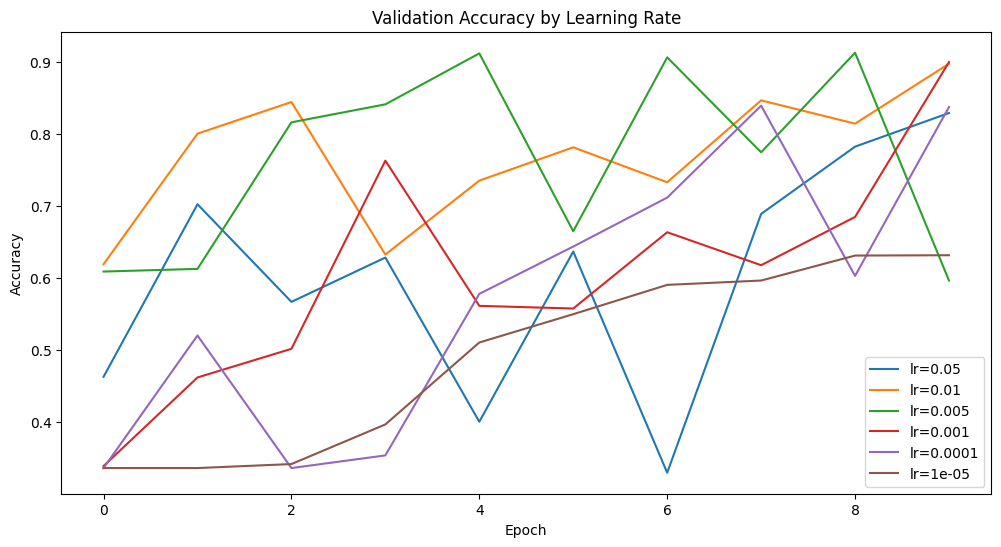


Best learning rate:0.005


In [12]:
from tensorflow.keras.callbacks import LearningRateScheduler
learning_rates=[5e-2,1e-2,5e-3,1e-3,1e-4,1e-5]
history_dict={}

print("Starting learning rate search...")
for lr in learning_rates:
    print(f"\nTesting learning rate:{lr}")
    model=build_cnn_model(lr)
    history=model.fit(x_train,y_train,
                        validation_split=0.35,
                        epochs=10,verbose=1)
    history_dict[lr]=history.history

plt.figure(figsize=(12,6))
for lr in learning_rates:
    plt.plot(history_dict[lr]['val_accuracy'],label=f'lr={lr}')
plt.title('Validation Accuracy by Learning Rate')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

best_lr = max(history_dict, 
             key=lambda k:np.max(history_dict[k]['val_accuracy']))
print(f"\nBest learning rate:{best_lr}")


Starting final training...
Epoch 1/40
126/126 ━━━━━━━━━━━━━━━━━━━━ 23s 109ms/step - accuracy: 0.6375 - loss: 2.1835 - val_accuracy: 0.3662 - val_loss: 8.6361
Epoch 2/40
126/126 ━━━━━━━━━━━━━━━━━━━━ 6s 51ms/step - accuracy: 0.8640 - loss: 0.3708 - val_accuracy: 0.6315 - val_loss: 1.0661
Epoch 3/40
126/126 ━━━━━━━━━━━━━━━━━━━━ 7s 52ms/step - accuracy: 0.9035 - loss: 0.2679 - val_accuracy: 0.4843 - val_loss: 2.1744
Epoch 4/40
126/126 ━━━━━━━━━━━━━━━━━━━━ 7s 52ms/step - accuracy: 0.9081 - loss: 0.2666 - val_accuracy: 0.6981 - val_loss: 0.8167
Epoch 5/40
126/126 ━━━━━━━━━━━━━━━━━━━━ 7s 53ms/step - accuracy: 0.9166 - loss: 0.2313 - val_accuracy: 0.3565 - val_loss: 2.8887
Epoch 6/40
126/126 ━━━━━━━━━━━━━━━━━━━━ 7s 53ms/step - accuracy: 0.9395 - loss: 0.1800 - val_accuracy: 0.3551 - val_loss: 6.4454
Epoch 7/40
126/126 ━━━━━━━━━━━━━━━━━━━━ 7s 53ms/step - accuracy: 0.9300 - loss: 0.1998 - val_accuracy: 0.3708 - val_loss: 7.1058
Epoch 8/40
126/126 ━━━━━━━━━━━━━━━━━━━━ 7s 53ms/step - accuracy: 0.

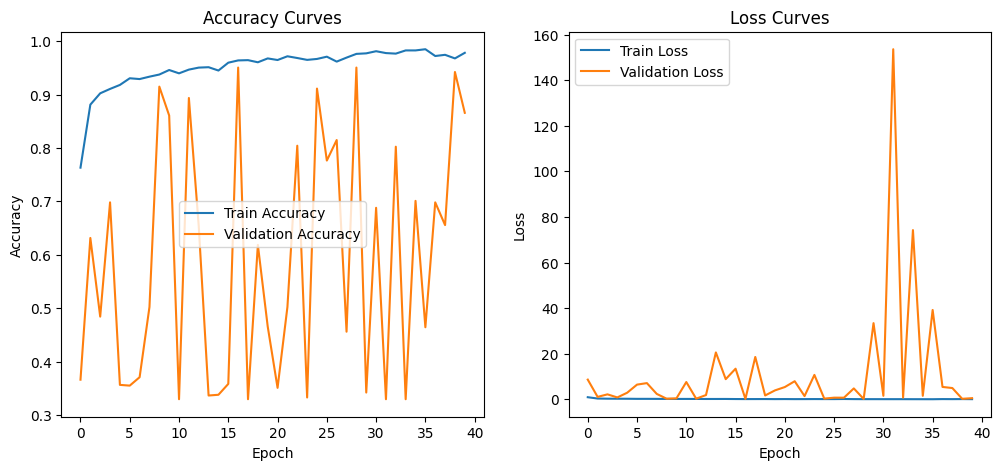

In [13]:
print("\nStarting final training...")
final_model=build_cnn_model(best_lr)
history=final_model.fit(x_train,y_train,
                         validation_split=0.35,
                         epochs=40,verbose=1)

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'],label='Train Accuracy')
plt.plot(history.history['val_accuracy'],label='Validation Accuracy')
plt.title('Accuracy Curves')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'],label='Train Loss')
plt.plot(history.history['val_loss'],label='Validation Loss')
plt.title('Loss Curves')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.show()

In [24]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Flatten,Dense,Dropout,BatchNormalization,Input
input_shape=(150,150,3)
filter1_size=64
filter2_size=128
filter3_size=128
filter4_size=256
filter5_size=256
filter6_size=512
filter_shape=(3,3)
pooling_shape=(2,2)
dense_layer1=1024
dense_layer2=512
dense_layer3=128
out_layer=len(classes)
dropout_rate1=0.2
dropout_rate2=0.3
dropout_rate3=0.4

lr_scheduler=tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                  factor=0.2,patience=3,min_lr=1e-9)


model = Sequential()
model.add(Input(input_shape))
model.add(Conv2D(filter1_size,filter_shape,activation='relu',padding="same"))
model.add(BatchNormalization(axis=-1))
model.add(MaxPooling2D(pooling_shape))

model.add(Conv2D(filter2_size,filter_shape,activation='relu',padding='same'))
model.add(BatchNormalization(axis=-1))

model.add(Conv2D(filter3_size,filter_shape,activation='relu',padding='same'))
model.add(BatchNormalization(axis=-1))
model.add(MaxPooling2D(pooling_shape))
model.add(Dropout(dropout_rate2))

model.add(Conv2D(filter4_size,filter_shape,activation='relu',padding='same'))
model.add(BatchNormalization(axis=-1))
model.add(MaxPooling2D(pooling_shape))
model.add(Dropout(dropout_rate2))

model.add(Conv2D(filter5_size,filter_shape,activation='relu',padding='same'))
model.add(BatchNormalization(axis=-1))
model.add(Dropout(dropout_rate3))

model.add(Conv2D(filter6_size,filter_shape,activation='relu',padding='same'))
model.add(BatchNormalization(axis=-1))
model.add(Flatten())

model.add(Dense(dense_layer1,activation='swish',kernel_regularizer='l2'))
model.add(Dropout(dropout_rate3))
model.add(Dense(dense_layer2,activation='swish',kernel_regularizer='l2'))
model.add(Dense(out_layer,activation='softmax'))
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()

Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_95 (Conv2D)                   │ (None, 150, 150, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_90               │ (None, 150, 150, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_78 (MaxPooling2D)      │ (None, 75, 75, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_96 (Conv2D)                   │ (None, 75, 75, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_91               │ (None, 75, 75, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_97 (Conv2D)                   │ (None, 75, 75, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_92               │ (None, 75, 75, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_79 (MaxPooling2D)      │ (None, 37, 37, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_78 (Dropout)                 │ (None, 37, 37, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_98 (Conv2D)                   │ (None, 37, 37, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_93               │ (None, 37, 37, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_80 (MaxPooling2D)      │ (None, 18, 18, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_79 (Dropout)                 │ (None, 18, 18, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_99 (Conv2D)                   │ (None, 18, 18, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_94               │ (None, 18, 18, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_80 (Dropout)                 │ (None, 18, 18, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_100 (Conv2D)                  │ (None, 18, 18, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_95               │ (None, 18, 18, 512)         │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 172,690,691 (658.76 MB)

 Trainable params: 172,688,003 (658.75 MB)

 Non-trainable params: 2,688 (10.50 KB)

Epoch 1/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 49s 284ms/step - accuracy: 0.6668 - loss: 56.6353 - val_accuracy: 0.3296 - val_loss: 88.7240 - learning_rate: 0.0010
Epoch 2/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 25s 195ms/step - accuracy: 0.7834 - loss: 24.4743 - val_accuracy: 0.3296 - val_loss: 24.0034 - learning_rate: 0.0010
Epoch 3/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 23s 186ms/step - accuracy: 0.8700 - loss: 7.1027 - val_accuracy: 0.5644 - val_loss: 5.7217 - learning_rate: 0.0010
Epoch 4/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 23s 181ms/step - accuracy: 0.8788 - loss: 4.8480 - val_accuracy: 0.5981 - val_loss: 6.1893 - learning_rate: 0.0010
Epoch 5/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 23s 182ms/step - accuracy: 0.8999 - loss: 4.4964 - val_accuracy: 0.8745 - val_loss: 3.4813 - learning_rate: 0.0010
Epoch 6/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 23s 186ms/step - accuracy: 0.9006 - loss: 3.6451 - val_accuracy: 0.7190 - val_loss: 3.7736 - learning_rate: 0.0010
Epoch 7/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 23s 186ms/step - accuracy:

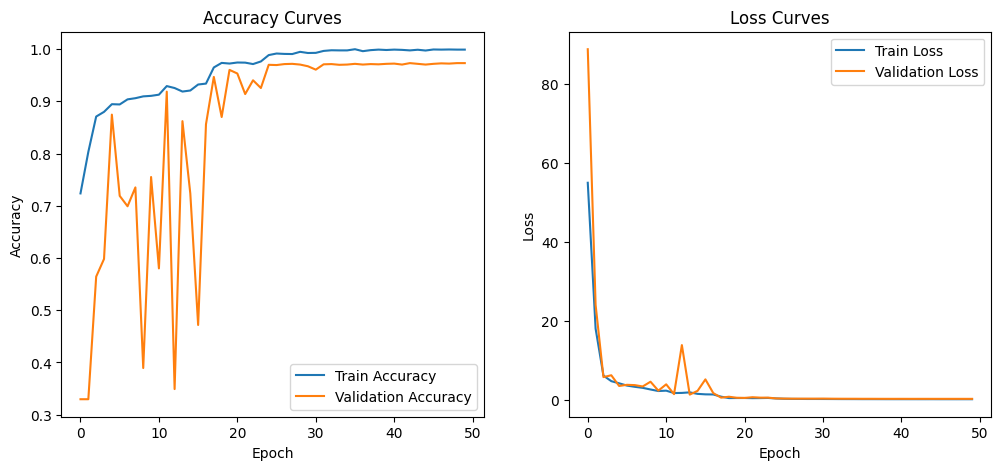

In [25]:
history=model.fit(x_train,y_train,validation_split=0.35,
                  epochs=50,verbose=1,callbacks=[lr_scheduler]
                 )

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'],label='Train Accuracy')
plt.plot(history.history['val_accuracy'],label='Validation Accuracy')
plt.title('Accuracy Curves')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'],label='Train Loss')
plt.plot(history.history['val_loss'],label='Validation Loss')
plt.title('Loss Curves')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.show()

53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step
Test Accuracy:0.9543
Precision:[0.97891037 0.93628319 0.94746377]
Recall:[0.99464286 0.93960924 0.92895204]
F1-Score:[0.98671391 0.93794326 0.93811659]

Classification Report:
              precision    recall  f1-score   support

     COVID19       0.98      0.99      0.99       560
      NORMAL       0.94      0.94      0.94       563
   PNEUMONIA       0.95      0.93      0.94       563

    accuracy                           0.95      1686
   macro avg       0.95      0.95      0.95      1686
weighted avg       0.95      0.95      0.95      1686



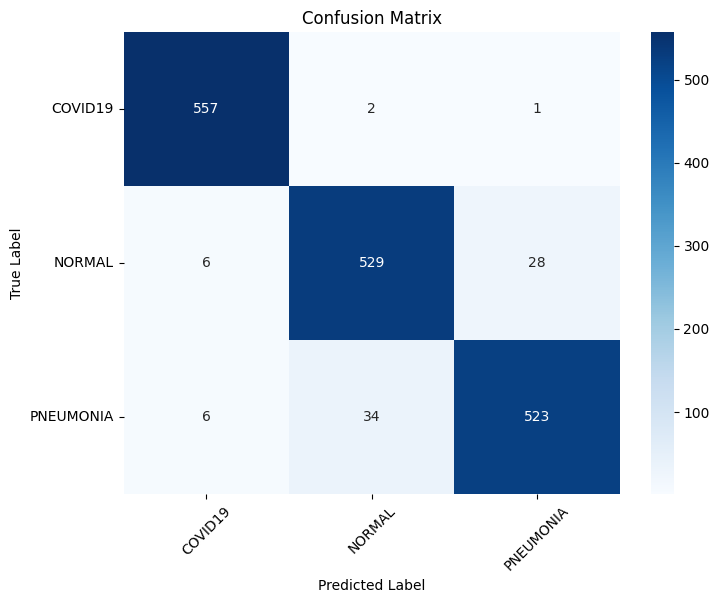

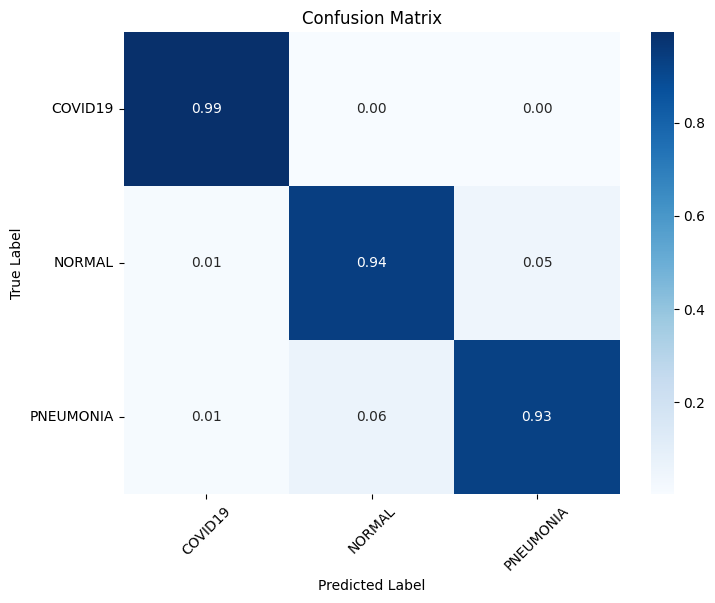

In [28]:
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,precision_score,recall_score,f1_score
import seaborn as sns

y_pred=model.predict(x_test)
y_pred_classes=np.argmax(y_pred,axis=1)
y_true=np.argmax(y_test,axis=1)

accuracy=accuracy_score(y_true,y_pred_classes)
precision=precision_score(y_true,y_pred_classes,average=None)
recall=recall_score(y_true,y_pred_classes,average=None)
f1=f1_score(y_true,y_pred_classes,average=None)

print(f"Test Accuracy:{accuracy:.4f}")
print(f"Precision:{precision:}")
print(f"Recall:{recall:}")
print(f"F1-Score:{f1:}\n")

print("Classification Report:")
print(classification_report(y_true,y_pred_classes,target_names=cls_names))

def plot_confusion_matrix(y_true,y_pred,classes,normalize=False):
    cm=confusion_matrix(y_true,y_pred)
    if normalize:
        cm=cm.astype('float')/cm.sum(axis=1)[:,np.newaxis]
    
    plt.figure(figsize=(8,6))
    sns.heatmap(cm,annot=True,fmt='.2f' if normalize else 'd',
                cmap='Blues',xticklabels=classes,yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.show()

plot_confusion_matrix(y_true,y_pred_classes,classes=cls_names)
plot_confusion_matrix(y_true,y_pred_classes,classes=cls_names,normalize=True)

# یادگیری انتقالی

In [6]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16, MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D,Dropout,Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [7]:
x_train=tf.image.resize(x_train,[224,224])
x_test=tf.image.resize(x_test,[224,224])

# VGG16

In [8]:
vgg_base=VGG16(weights='imagenet',include_top=False,input_shape=(224,224,3))
vgg_base.trainable = False

inputs=Input(shape=(224,224,3))
x=vgg_base(inputs,training=False)
x=GlobalAveragePooling2D()(x)
x=Dense(512,activation='relu')(x)
x=Dropout(0.5)(x)
predictions=Dense(num_cls,activation='softmax')(x)

vgg_model=Model(inputs=inputs,outputs=predictions)

vgg_model.compile(optimizer='adam',
                        loss='categorical_crossentropy',
                        metrics=['accuracy'])
trained_vgg=vgg_model.fit(x_train,y_train,epochs=15,validation_split=0.35,batch_size=32)

vgg_base.trainable=True
num_layers=len(vgg_base.layers)

for layer in vgg_base.layers[:15]:
    layer.trainable=False

vgg_model.compile(optimizer=Adam(learning_rate=1e-5),
                       loss='categorical_crossentropy',
                       metrics=['accuracy'])
fine_trained_vgg=vgg_model.fit(x_train,y_train,epochs=30,initial_epoch=15,
                         validation_split=0.35,batch_size=32)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/15
126/126 ━━━━━━━━━━━━━━━━━━━━ 54s 305ms/step - accuracy: 0.6360 - loss: 0.7987 - val_accuracy: 0.8639 - val_loss: 0.3805
Epoch 2/15
126/126 ━━━━━━━━━━━━━━━━━━━━ 23s 182ms/step - accuracy: 0.8608 - loss: 0.3616 - val_accuracy: 0.8935 - val_loss: 0.2924
Epoch 3/15
126/126 ━━━━━━━━━━━━━━━━━━━━ 23s 185ms/step - accuracy: 0.9048 - loss: 0.2838 - val_accuracy: 0.9032 - val_loss: 0.2717
Epoch 4/15
126/126 ━━━━━━━━━━━━━━━━━━━━ 24s 187ms/step - accuracy: 0.9141 - loss: 0.2579 - val_accuracy: 0.9167 - val_loss: 0.2312
Epoch 5/15
126/126 ━━━━━━━━━━━━━━━━━━━━ 24s 188ms/step - accuracy: 0.9156 - loss: 0.2328 - val_accuracy: 0.9199 - val_loss: 0.2117
Epoch 6/15
126/126 ━━━━━━━━━━━━━━━━━━━━ 24s 191ms/step - accuracy: 0.9291 - loss: 0.2022 - val_accuracy: 0.9093 - val_loss: 0.2559
Epoch 7/15
126/126 ━━━━━━━━━━━━━━━━━━━━ 24s 194ms/step - accuracy: 0.9337 - loss: 0.2030 - val_accuracy: 0.9083 - val_loss: 0.2444
Epoch 8/15
126/126 ━━━━━━━━━━━━━

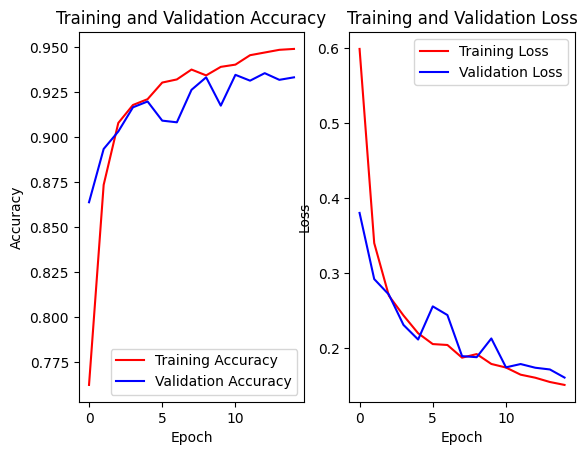

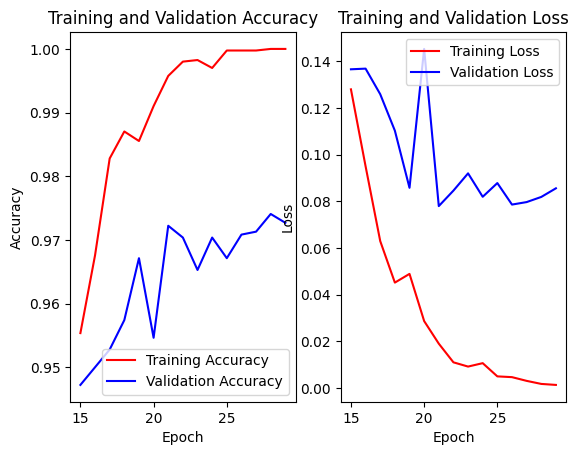

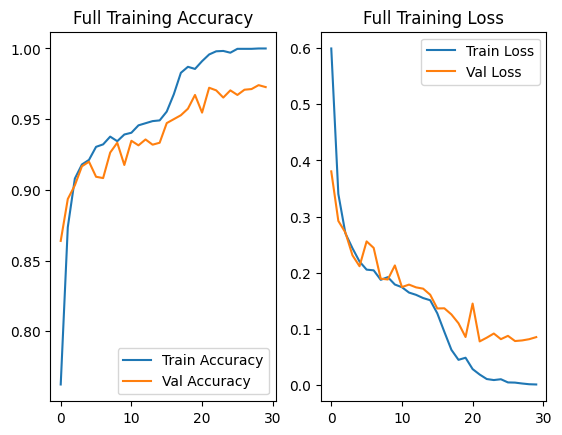

In [9]:
def plot_training_history(train,initial_epoch=0):
    acc=train.history['accuracy']
    val_acc=train.history['val_accuracy']
    loss=train.history['loss']
    val_loss=train.history['val_loss']
    
    epochs=range(initial_epoch,initial_epoch+len(acc))
    
    plt.subplot(1,2,1)
    plt.plot(epochs,acc,'r',label='Training Accuracy')
    plt.plot(epochs,val_acc,'b',label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.subplot(1,2,2)
    plt.plot(epochs,loss,'r',label='Training Loss')
    plt.plot(epochs,val_loss,'b',label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

plot_training_history(train=trained_vgg,initial_epoch=0)
plot_training_history(train=fine_trained_vgg,initial_epoch=15)

def combine_trains(t1,t2):
    combined={}
    for key in t1.history.keys():
        combined[key]=t1.history[key]+t2.history[key]
    return combined

full_train=combine_trains(trained_vgg,fine_trained_vgg)

plt.subplot(1,2,1)
plt.plot(full_train['accuracy'],label='Train Accuracy')
plt.plot(full_train['val_accuracy'],label='Val Accuracy')
plt.title('Full Training Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(full_train['loss'],label='Train Loss')
plt.plot(full_train['val_loss'],label='Val Loss')
plt.title('Full Training Loss')
plt.legend()
plt.show()

53/53 ━━━━━━━━━━━━━━━━━━━━ 17s 307ms/step
Test Accuracy: 0.9561091340450771
Precision: [0.98387097 0.93928571 0.94542254]
Recall: [0.98035714 0.93428064 0.95381883]
F1-Score: [0.98211091 0.93677649 0.94960212]

Classification Report:
              precision    recall  f1-score   support

     COVID19       0.98      0.98      0.98       560
      NORMAL       0.94      0.93      0.94       563
   PNEUMONIA       0.95      0.95      0.95       563

    accuracy                           0.96      1686
   macro avg       0.96      0.96      0.96      1686
weighted avg       0.96      0.96      0.96      1686



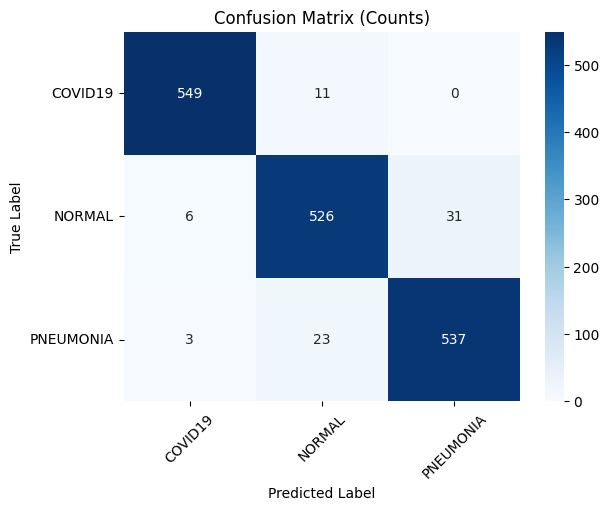

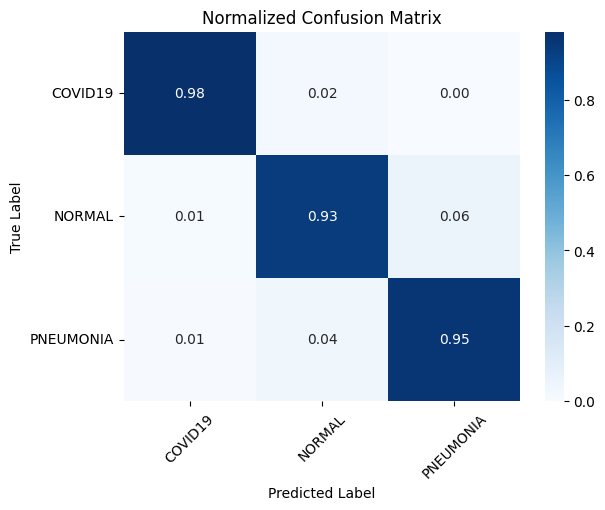

In [10]:
import seaborn as sns
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,precision_score,recall_score,f1_score

y_pred=vgg_model.predict(x_test)
y_pred_classes=np.argmax(y_pred,axis=1)
y_true=np.argmax(y_test,axis=1)

accuracy=accuracy_score(y_true,y_pred_classes)
precision=precision_score(y_true,y_pred_classes,average=None)
recall=recall_score(y_true,y_pred_classes,average=None)
f1=f1_score(y_true,y_pred_classes,average=None)

print(f"Test Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}\n")

print("Classification Report:")
print(classification_report(y_true,y_pred_classes,target_names=cls_names))

def plot_confusion_matrix(y_true,y_pred,classes,normalize=False,title='Confusion Matrix'):
    cm=confusion_matrix(y_true,y_pred)
    if normalize:
        cm=cm.astype('float')/cm.sum(axis=1)[:,np.newaxis]
        fmt='.2f'
    else:
        fmt='d'
    
    sns.heatmap(cm,annot=True,fmt=fmt,cmap='Blues', 
                xticklabels=classes,yticklabels=classes)
    plt.title(title)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.show()

plot_confusion_matrix(y_true,y_pred_classes,classes=cls_names, 
                     title='Confusion Matrix (Counts)')
plot_confusion_matrix(y_true,y_pred_classes,classes=cls_names,normalize=True,
                     title='Normalized Confusion Matrix')

# MobileNetV2

In [23]:
img_size=(224,224) 
batch_size=32

datagen=ImageDataGenerator(rescale=1./255,validation_split=0.35 )

train_generator=datagen.flow_from_directory(
    '../input/augmented-chest-xray-covid19-pneumonia/augmented_train',
    target_size=img_size,batch_size=batch_size,
    class_mode='categorical',subset='training',
    shuffle=True,seed=42)

val_generator = datagen.flow_from_directory(
    '../input/augmented-chest-xray-covid19-pneumonia/augmented_train',
    target_size=img_size,batch_size=batch_size,
    class_mode='categorical',subset='validation',
    shuffle=False,seed=42)


test_datagen=ImageDataGenerator(rescale=1./255)

test_generator=test_datagen.flow_from_directory(
    '../input/augmented-chest-xray-covid19-pneumonia/augmented_test',target_size=img_size,
    batch_size=batch_size,class_mode='categorical')

Found 4012 images belonging to 3 classes.
Found 2158 images belonging to 3 classes.
Found 1686 images belonging to 3 classes.


In [26]:
mobilenet_base=MobileNetV2(weights='imagenet',include_top=False,input_shape=(224,224,3))
mobilenet_base.trainable = False

x=mobilenet_base.output
x=GlobalAveragePooling2D()(x)
x=Dense(256,activation='relu')(x)
x=Dropout(0.3)(x)
predictions=Dense(num_cls,activation='softmax')(x)

mobilenet_model=Model(inputs=mobilenet_base.input,outputs=predictions)

mobilenet_model.compile(optimizer=Adam(learning_rate=1e-3),
                        loss='categorical_crossentropy',
                        metrics=['accuracy'])
trained_mobilenet=mobilenet_model.fit(train_generator,batch_size=batch_size,
    epochs=10,validation_data=val_generator)

mobilenet_base.trainable=True
num_layers=len(mobilenet_base.layers)
fine_tune_at=int(num_layers*0.7)

for layer in mobilenet_base.layers[:fine_tune_at]:
    layer.trainable=False

mobilenet_model.compile(optimizer=Adam(learning_rate=1e-5),
                       loss='categorical_crossentropy',
                       metrics=['accuracy'])

history_mobilenet_fine=mobilenet_model.fit(
    train_generator,epochs=30,initial_epoch=10,
    validation_data=val_generator,batch_size=batch_size)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


126/126 ━━━━━━━━━━━━━━━━━━━━ 88s 618ms/step - accuracy: 0.8088 - loss: 0.4382 - val_accuracy: 0.9268 - val_loss: 0.1979
Epoch 2/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 70s 536ms/step - accuracy: 0.9254 - loss: 0.1869 - val_accuracy: 0.9467 - val_loss: 0.1491
Epoch 3/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 69s 532ms/step - accuracy: 0.9515 - loss: 0.1280 - val_accuracy: 0.9467 - val_loss: 0.1431
Epoch 4/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 71s 542ms/step - accuracy: 0.9621 - loss: 0.1052 - val_accuracy: 0.9541 - val_loss: 0.1252
Epoch 5/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 71s 541ms/step - accuracy: 0.9681 - loss: 0.0853 - val_accuracy: 0.9551 - val_loss: 0.1279
Epoch 6/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 70s 540ms/step - accuracy: 0.9664 - loss: 0.0850 - val_accuracy: 0.9495 - val_loss: 0.1322
Epoch 7/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 70s 541ms/step - accuracy: 0.9624 - loss: 0.0916 - val_accuracy: 0.9560 - val_loss: 0.1323
Epoch 8/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 71s 541ms/step - accuracy: 0.9701 - loss: 0.0689 - val

In [40]:
test_generator=test_datagen.flow_from_directory(
    '../input/augmented-chest-xray-covid19-pneumonia/augmented_test',target_size=img_size,
    batch_size=batch_size,class_mode='categorical',shuffle=False)

Found 1686 images belonging to 3 classes.


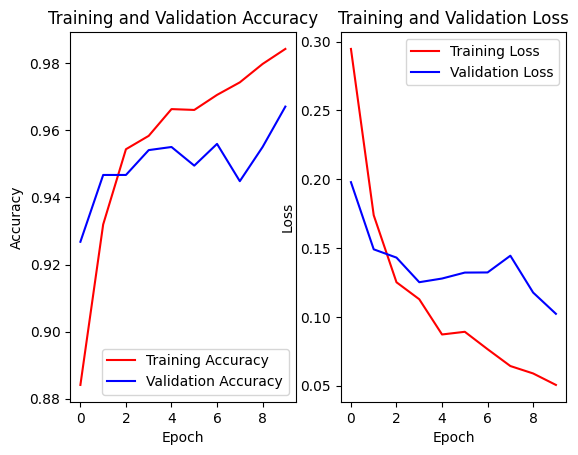

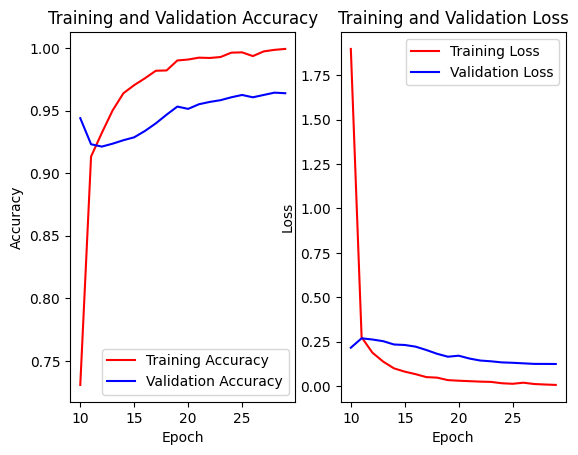

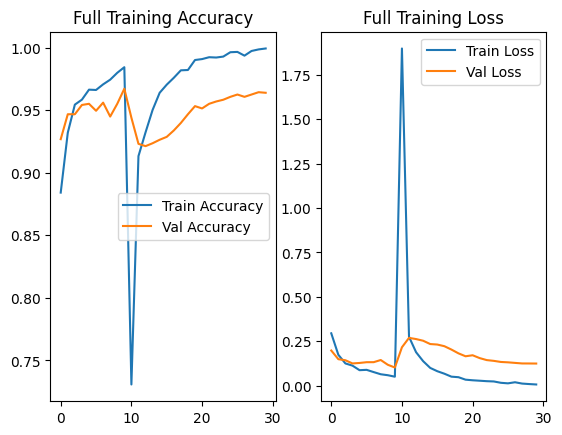

In [27]:
def plot_training_history(train,initial_epoch=0):
    acc=train.history['accuracy']
    val_acc=train.history['val_accuracy']
    loss=train.history['loss']
    val_loss=train.history['val_loss']
    
    epochs=range(initial_epoch,initial_epoch+len(acc))
    
    plt.subplot(1,2,1)
    plt.plot(epochs,acc,'r',label='Training Accuracy')
    plt.plot(epochs,val_acc,'b',label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.subplot(1,2,2)
    plt.plot(epochs,loss,'r',label='Training Loss')
    plt.plot(epochs,val_loss,'b',label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

plot_training_history(trained_mobilenet,initial_epoch=0)
plot_training_history(history_mobilenet_fine,initial_epoch=10)

def combine_trains(t1,t2):
    combined={}
    for key in t1.history.keys():
        combined[key]=t1.history[key]+t2.history[key]
    return combined

full_train=combine_trains(trained_mobilenet,history_mobilenet_fine)

plt.subplot(1,2,1)
plt.plot(full_train['accuracy'],label='Train Accuracy')
plt.plot(full_train['val_accuracy'],label='Val Accuracy')
plt.title('Full Training Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(full_train['loss'],label='Train Loss')
plt.plot(full_train['val_loss'],label='Val Loss')
plt.title('Full Training Loss')
plt.legend()
plt.show()

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Test Accuracy: 0.9323843416370107
Precision: [0.99249531 0.89134126 0.91843972]
Recall: [0.94464286 0.93250444 0.92007105]
F1-Score: [0.96797804 0.91145833 0.91925466]

Classification Report:
              precision    recall  f1-score   support

     COVID19       0.99      0.94      0.97       560
      NORMAL       0.89      0.93      0.91       563
   PNEUMONIA       0.92      0.92      0.92       563

    accuracy                           0.93      1686
   macro avg       0.93      0.93      0.93      1686
weighted avg       0.93      0.93      0.93      1686



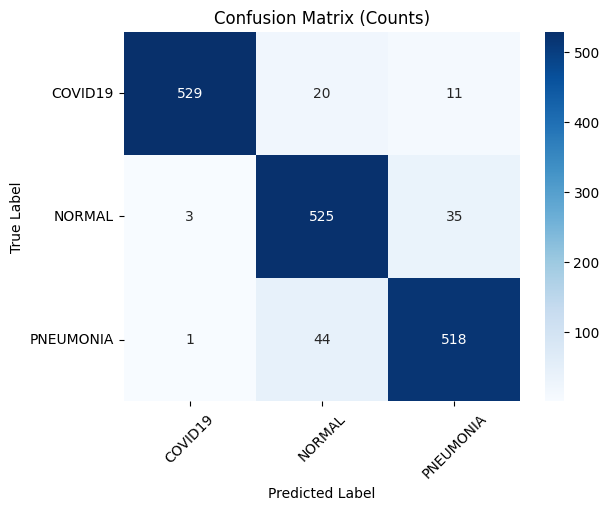

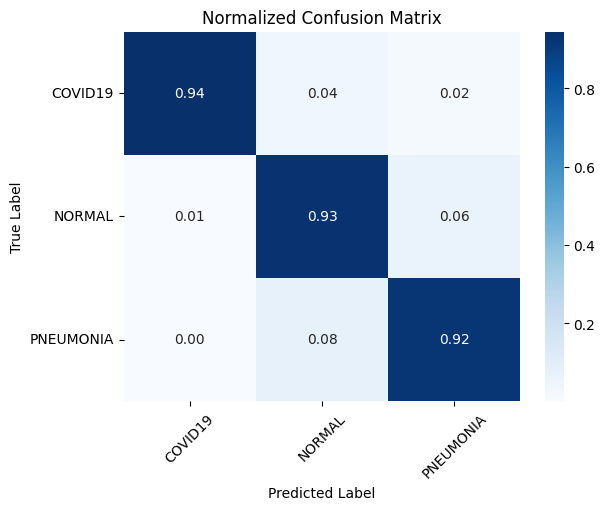

In [41]:
import seaborn as sns
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,precision_score,recall_score,f1_score

y_pred_probs=mobilenet_model.predict(test_generator,steps=len(test_generator),verbose=0)
y_pred_classes=np.argmax(y_pred_probs,axis=1)
y_true=test_generator.classes

accuracy=accuracy_score(y_true,y_pred_classes)
precision=precision_score(y_true,y_pred_classes,average=None)
recall=recall_score(y_true,y_pred_classes,average=None)
f1=f1_score(y_true,y_pred_classes,average=None)

print(f"Test Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}\n")

print("Classification Report:")
print(classification_report(y_true,y_pred_classes,target_names=cls_names))

def plot_confusion_matrix(y_true,y_pred,classes,normalize=False,title='Confusion Matrix'):
    cm=confusion_matrix(y_true,y_pred)
    if normalize:
        cm=cm.astype('float')/cm.sum(axis=1)[:,np.newaxis]
        fmt='.2f'
    else:
        fmt='d'
    
    sns.heatmap(cm,annot=True,fmt=fmt,cmap='Blues', 
                xticklabels=classes,yticklabels=classes)
    plt.title(title)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.show()

plot_confusion_matrix(y_true,y_pred_classes,classes=cls_names, 
                     title='Confusion Matrix (Counts)')
plot_confusion_matrix(y_true,y_pred_classes,classes=cls_names,normalize=True,
                     title='Normalized Confusion Matrix')